In [1]:
import pandas as pd
from umap import UMAP
from ivis import Ivis
import numpy as np
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
from hdbscan import HDBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

tqdm.pandas(desc="progess: ")

In [2]:
def sample_data(df, fraction, contamination, seed):
    X_n = int(df[df.outlier_label == 1].shape[0] * fraction)
    y_n = int(X_n * contamination)

    df = df.iloc[np.random.RandomState(seed=seed).permutation(len(df))]
    df = df[df["outlier_label"] == 1].head(X_n).append(
        df[df["outlier_label"] == -1].head(y_n))
    df = df.reset_index(drop=True)
    return df

def reject_outliers(sr, iq_range=0.5):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = np.quantile(sr, [pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return ((np.abs(sr - median)) >= iqr/2)

In [3]:
umap_2d = UMAP(metric="cosine", set_op_mix_ratio=1.0,
               n_components=2, random_state=42)

In [4]:
# parameters
data_path = "/home/philipp/projects/dad4td/data/processed/20_news_imdb.pkl"
doc2vec_model_path = "/home/philipp/projects/dad4td/models/apnews_dbow/doc2vec.bin"
doc2vec_model = Doc2Vec.load(doc2vec_model_path)

# get test data
df = pd.read_pickle(data_path)
df = df.where(df.text.map(len) > 5)
df = sample_data(df, fraction=1.0, contamination=0.1, seed=1)

# vectorize
df

text  target  \
0      I have a 5 minute rule (sometimes I'll leave l...    -1.0   
1      This comes close to the worst movie I've ever ...    -1.0   
2      "Go Fish" garnered Rose Troche rightly or wron...    -1.0   
3      A group of friends receive word from a pal who...    -1.0   
4      96 minutes of this is cruel..and I love the ol...    -1.0   
...                                                  ...     ...   
54995  \nAs I'm sure others will have pointed out to ...    16.0   
54996  \nI am not an expert in the cryptography scien...    11.0   
54997  JB>  \nJB>    Ron Roth recommends: "Once you h...    13.0   
54998  \n\nDo you have a terminal cold? Karabag is 'T...    17.0   
54999  \n\n\nLikewise for me please. First time I've ...     1.0   

                       title  outlier_label  
0                       imdb            1.0  
1                       imdb            1.0  
2                       imdb            1.0  
3                       imdb            1.0  
4                       imdb            1.0  
...                      ...            ...  
54995     talk.politics.guns           -1.0  
54996              sci.crypt           -1.0  
54997                sci.med           -1.0  
54998  talk.politics.mideast           -1.0  
54999          comp.graphics           -1.0  

[55000 rows x 4 columns]

In [5]:
df.title.value_counts()

imdb                        50000
comp.graphics                 277
rec.sport.baseball            276
misc.forsale                  275
rec.motorcycles               274
sci.crypt                     267
sci.electronics               266
soc.religion.christian        260
sci.med                       259
comp.sys.ibm.pc.hardware      257
sci.space                     257
rec.autos                     255
rec.sport.hockey              254
comp.sys.mac.hardware         252
comp.os.ms-windows.misc       251
talk.politics.mideast         244
comp.windows.x                244
talk.politics.guns            236
alt.atheism                   225
talk.politics.misc            205
talk.religion.misc            166
Name: title, dtype: int64

In [6]:
dim_reducer = UMAP(metric="cosine", set_op_mix_ratio=1.0,
               n_components=256, random_state=42)

In [7]:
# ivis
ivis_reducer = Ivis(embedding_dims=1, k=5, n_epochs_without_progress=5, model="maaten", distance="pn")

In [8]:
# get doc2vec vectors
X = df.text
X = X.progress_apply(lambda x: simple_preprocess(x))
docvecs = X.progress_apply(lambda x: doc2vec_model.infer_vector(x))
docvecs = list(docvecs)
docvecs

progess: 100%|██████████| 55000/55000 [05:56<00:00, 154.39it/s]


[array([ 0.3330979 , -0.0339263 ,  0.22832592,  0.08707888,  0.13640246,
         0.05797769, -0.17114112, -0.25051832,  0.1402758 ,  0.47315454,
        -0.26572344,  0.01940255, -0.36408573, -0.11530811, -0.34195638,
         0.4840781 , -0.0290575 ,  0.12932743, -0.21074732, -0.18635996,
        -0.35864928,  0.19032246,  0.4006612 ,  0.21499287,  0.30739036,
        -0.01201997, -0.01530531,  0.09337086, -0.15811646,  0.3237153 ,
        -0.50983995,  0.10577225,  0.49746162,  0.1669068 ,  0.07781281,
        -0.013277  ,  0.09848468,  0.02478337, -0.65342194,  0.11024658,
         0.08655438, -0.27068755, -0.3585125 ,  0.26226655,  0.20108522,
        -0.06945856, -0.07152226,  0.0994534 ,  0.0604847 ,  0.73757833,
        -0.24093862, -0.07283404, -0.1855989 ,  0.18033423, -0.02193779,
        -0.38545555,  0.07839161, -0.07120313, -0.1483429 , -0.1486016 ,
         0.14224468, -0.04561197,  0.2317868 ,  0.15323433,  0.0760621 ,
        -0.11467331,  0.40166548, -0.3199203 ,  0.3

In [9]:
# UMAP reduction
dim_reduced_vecs = dim_reducer.fit_transform(docvecs)

In [10]:
scores = ivis_reducer.fit_transform(dim_reduced_vecs)

  5%|▌         | 2812/55000 [00:00<00:01, 27829.74it/s]

Building KNN index


100%|██████████| 55000/55000 [00:01<00:00, 30941.19it/s]


Extracting KNN from index


100%|█████████▉| 54984/55000 [00:03<00:00, 16030.09it/s]


Training neural network
Epoch 1/1000
430/430 [==============================] - 14s 33ms/step - loss: 5.9658
Epoch 2/1000
430/430 [==============================] - 13s 30ms/step - loss: 0.6587
Epoch 3/1000
430/430 [==============================] - 13s 31ms/step - loss: 0.0578
Epoch 4/1000
430/430 [==============================] - 13s 31ms/step - loss: 0.4728
Epoch 5/1000
430/430 [==============================] - 13s 31ms/step - loss: 0.1697
Epoch 6/1000
430/430 [==============================] - 13s 31ms/step - loss: 0.1641
Epoch 7/1000
430/430 [==============================] - 13s 31ms/step - loss: 3.3833
Epoch 8/1000
430/430 [==============================] - 14s 32ms/step - loss: 0.0000e+00
Epoch 9/1000
430/430 [==============================] - 13s 31ms/step - loss: 0.0000e+00
Epoch 10/1000
430/430 [==============================] - 14s 32ms/step - loss: 8.3426
Epoch 11/1000
430/430 [==============================] - 13s 29ms/step - loss: 0.0000e+00
Epoch 12/1000
430/430 [====

In [11]:
df["ivis_scores"] = scores

In [12]:
contamination = 0.1
preds = reject_outliers(scores, iq_range=1.0-contamination)
df["pred"] = preds
df["Prediction"] = df.pred + df.outlier_label
df = df.replace({"Prediction":{-1.0:"False Inlier",0.0:"True Outlier",1.0:"True Inlier",2.0:"False Outlier"}})

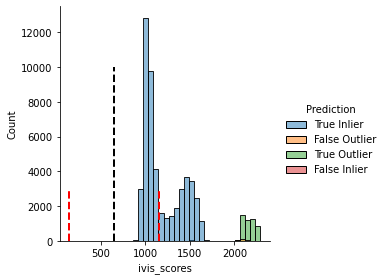

In [13]:
df["Label"] = df.outlier_label.map(lambda x: {-1.0:"outlier", 1.0:"inlier"}[x])
sns.displot(data=df,x="ivis_scores", hue="Prediction", palette="tab10", height=4, bins=25)
plt.plot([145.75, 145.75], [0, 3000], color="red", linestyle='dashed', linewidth=2)
plt.plot([1157.28, 1157.28], [0, 3000], color="red", linestyle='dashed', linewidth=2)
plt.plot([651, 651], [0, 10000], color="black", linestyle='dashed', linewidth=2)
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/hist-apnews-ivis.svg", format="svg")

In [14]:
sr = scores
pcnt = (1 - 0.9) / 2
qlow, median, qhigh = np.quantile(sr, [pcnt, 0.50, 1-pcnt])
print(qlow, median, qhigh)
iqr = qhigh - qlow
print(iqr)
# x - median >= iqr/2
# x - 650 >= 505
print(median+iqr/2, median-iqr/2)

974.6914093017577 1109.4690551757812 2144.3947143554688
1169.7033050537111
1694.3207077026368 524.6174026489257


In [15]:
vecs_2d = umap_2d.fit_transform(dim_reduced_vecs)

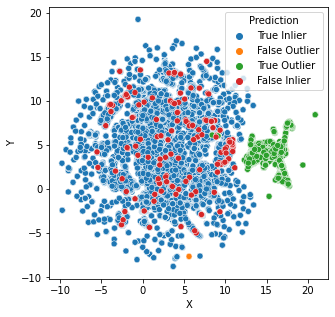

In [16]:
size = 5
plt.figure(figsize=(size,size))
df["X"] = vecs_2d[:, 0]
df["Y"] = vecs_2d[:, 1]
df["pred"] = preds
df["vis_label"] = df.pred + df.outlier_label
df = df.replace({"vis_label":{-1.0:"False Inlier",0.0:"True Outlier",1.0:"True Inlier",2.0:"False Outlier"}})
sns.scatterplot(data=df, x="X", y="Y", hue="Prediction", palette="tab10")
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/2d-apnews-ivis.svg", format="svg")

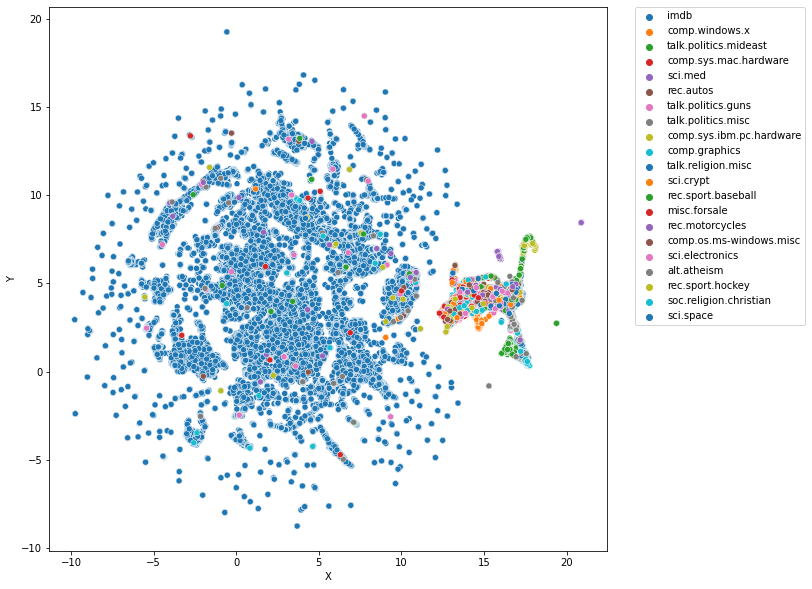

In [17]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df, x="X", y="Y", hue="title", palette="tab10")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/2d-apnews-title.svg", format="svg")

## HDBSCAN

In [18]:
cluster_model = HDBSCAN(min_cluster_size=50)
cluster_pred = cluster_model.fit_predict(dim_reduced_vecs)

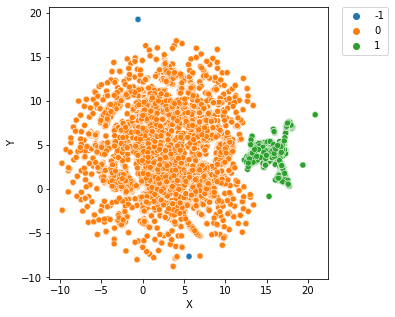

In [19]:
size = 5
plt.figure(figsize=(size,size))
df["cluster"] = cluster_pred
sns.scatterplot(data=df, x="X", y="Y", hue="cluster", palette="tab10")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

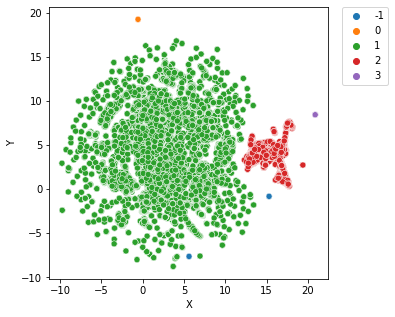

In [20]:
size = 5
plt.figure(figsize=(size,size))
cluster_model = HDBSCAN(min_cluster_size=30)
cluster_pred = cluster_model.fit_predict(dim_reduced_vecs)

df["cluster"] = cluster_pred
sns.scatterplot(data=df, x="X", y="Y", hue="cluster", palette="tab10")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

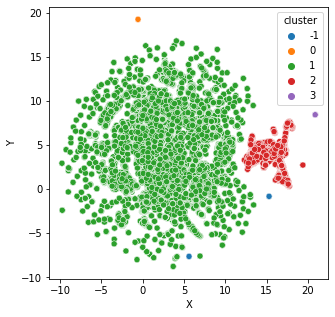

In [21]:
size = 5
plt.figure(figsize=(size,size))
df["cluster"] = cluster_pred
sns.scatterplot(data=df, x="X", y="Y", hue="cluster", palette="tab10")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/2d-apnews-hdbscan.svg", format="svg")

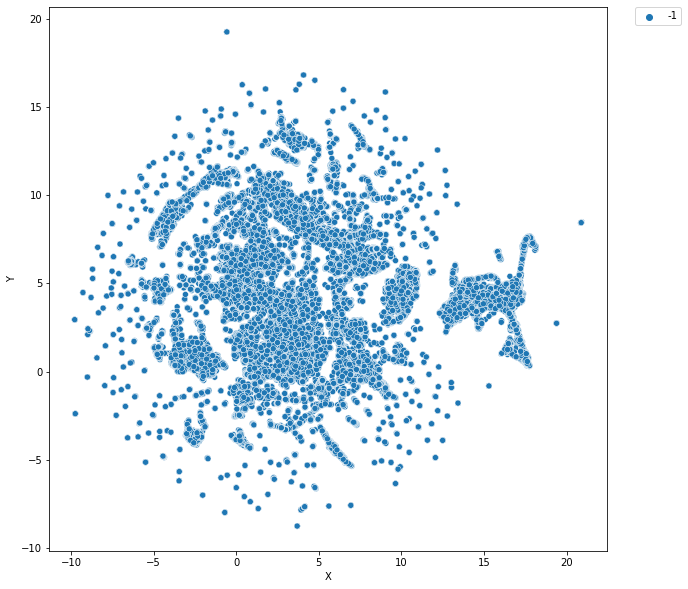

In [22]:
cluster_model = HDBSCAN(min_cluster_size=20)
cluster_pred = cluster_model.fit_predict(docvecs)

plt.figure(figsize=(10,10))
df["cluster"] = cluster_pred
sns.scatterplot(data=df, x="X", y="Y", hue="cluster", palette="tab10")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [23]:
from sklearn.metrics import f1_score
a = reject_outliers(scores, iq_range=0.9)
a = [-1 if x else 1 for x in a]
f1_score(df.outlier_label, a, average='macro')

0.9774368945613776

In [24]:
bin_cluster = [-1 if x==2 else 1 for x in cluster_pred]
f1_score(df.outlier_label, bin_cluster, average='macro')

0.47619047619047616

## t-SNE

In [25]:
from sklearn.manifold import TSNE

tsnre_reduced = TSNE().fit_transform(docvecs)

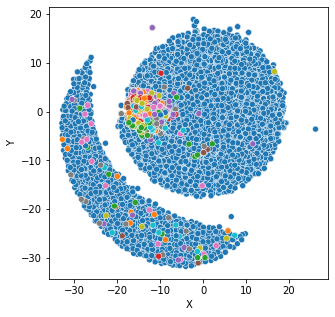

In [26]:
size = 5
plt.figure(figsize=(size,size))
df["Xt"] = tsnre_reduced[:, 0]
df["Yt"] = tsnre_reduced[:, 1]
sns.scatterplot(data=df, x="Xt", y="Yt", hue="title", palette="tab10")
plt.legend('',frameon=False)
plt.xlabel("X")
plt.ylabel("Y")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/apnews-tsne.svg", format="svg")

## kMeans

In [27]:
from sklearn.cluster import KMeans

kcluster_pred = KMeans(n_clusters=6).fit_predict(dim_reduced_vecs)

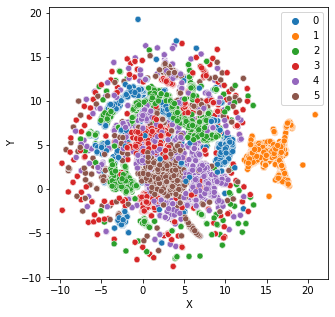

In [28]:
size = 5
plt.figure(figsize=(size,size))
df["kcluster"] = kcluster_pred
sns.scatterplot(data=df, x="X", y="Y", hue="kcluster", palette="tab10")
L=plt.legend()
L.get_texts()[0].set_text('0')
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/2d-apnews-kmeans.svg", format="svg")

In [29]:
from sklearn.metrics import f1_score
bin_cluster = [-1 if x==1 else 1 for x in kcluster_pred]
f1_score(df.outlier_label, bin_cluster, average='macro')

0.9782585856954342

## PCA

In [30]:
from sklearn.decomposition import PCA

#pca_reduced = PCA(n_components=256).fit_transform(docvecs)

In [31]:
pca_2d = PCA(n_components=2).fit_transform(docvecs)

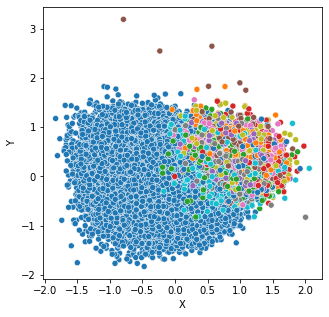

In [32]:
size = 5
plt.figure(figsize=(size,size))
df["Xp"] = pca_2d[:, 0]
df["Yp"] = pca_2d[:, 1]
sns.scatterplot(data=df, x="Xp", y="Yp", hue="title", palette="tab10")
plt.legend('',frameon=False)
plt.xlabel("X")
plt.ylabel("Y")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/apnews-pca.svg", format="svg")

In [33]:
pca_reduced = PCA(n_components=20).fit_transform(docvecs)

In [ ]:
cluster_pred = KMeans(n_clusters=6).fit_predict(pca_reduced)

size = 5
plt.figure(figsize=(size,size))
df["Xp"] = pca_2d[:, 0]
df["Yp"] = pca_2d[:, 1]
df["cluster"] = cluster_pred
sns.scatterplot(data=df, x="Xp", y="Yp", hue="cluster", palette="tab10")
#plt.legend('',frameon=False)
plt.xlabel("X")
plt.ylabel("Y")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("/home/philipp/projects/dad4td/thesis/pictures/wiki_amazonapnews-pca-kmeans.svg", format="svg")

In [37]:
cluster_model = HDBSCAN(min_cluster_size=50)
cluster_pred = cluster_model.fit_predict(pca_reduced)

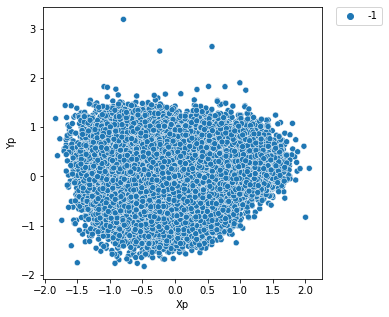

In [38]:
size = 5
plt.figure(figsize=(size,size))
df["cluster"] = cluster_pred
sns.scatterplot(data=df, x="Xp", y="Yp", hue="cluster", palette="tab10")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [39]:
bin_cluster = [-1 if x==1 else 1 for x in cluster_pred]
f1_score(df.outlier_label, bin_cluster, average='macro')

0.47619047619047616